# M1.3 Naive Bayes Classifier
 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m1_3_naive_bayes.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m1_3_naive_bayes.ipynb)  



### Learning Objectives
By working through this notebook, you will learn:
1. Basics of probability theory: prior probabilities, conditional probabilities
2. What Bayes' theorem is and how to use it to calculate the likelihood of an event 
3. What the naive bayes assumption is
2. How we can construct a Naive Bayes' Classifier and use it for text classification

### Load general packages

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Counter is a useful package takes as input a list of elements (e.g. a list of words in a text) and 
#  returns a dictionary how many times each element occurs with key (e.g. "apple" ): value ( e.g. 5) .
from collections import Counter, defaultdict
from datasets import load_dataset

## 1. Introduction

Machine Learning often boiles down to simply learning the statistics of our datasets. For many especially for classification tasks, we want to know: 

What is the probability that:
1. This sentiment of this review is positive/negative?
2. That this email is spam?
3. This social media post contains hate speech?

Luckily we don't need to reinvent the wheel and can borrow much theory from probability theory. 
In this notebook we will walk through the steps of computing probabilities, discuss a few different type of probabilities and finally use it to constructe an algorithm we can use for classification, the **Naive Bayes Classifier**. Despite its simplicity, Naive Bayes often performs remarkably well for NLP tasks like spam detection, sentiment analysis, and document categorization.



---
## 2. Understanding Probabilities & Bayes' Theorem 

Imagine you receive an email with the words: "winner", "free", "click", "now".
Your intuition probably tells you this is spam! Why? Because you've learned from experience that these words appear much more frequently in spam than in legitimate emails.
Naive Bayes formalizes this intuition using probability theory.

**Core Question:** Given a text document, we want to answer: **What is the probability that this document belongs to class C?**

### 2.1 Task Formalization

Let's say we have a list of documents: 
- The **Evidence**: `Documents = [document_1, document_2, ..., document_3]`. 
- The **Classes**: `Classes = [spam, not_spam]`

#### Bag-Of-Words (BOW)
- For now also let's assume that each document is represented as a **Bag-Of-Words (BOW)** 
- In the BOW we neglect the order of the words in a document and only count for each word in the document how often it appears. As you may realize we loose a lot of information this way, but it makes it very easy to process text for simple machine learning models. 

![bow_fig](https://miro.medium.com/v2/0*cf1wq8eIix-Z2qIf.png)

Counter({'the': 8, 'and': 6, 'i': 5, 'you': 4, 'be': 4, 'were': 3, 'see': 3, 'we': 2, 'my': 2, 'on': 2, 'a': 2, "i'll": 2, 'both': 1, 'young': 1, 'when': 1, 'first': 1, 'saw': 1, 'close': 1, 'eyes': 1, 'flashback': 1, 'starts': 1, "i'm": 1, 'standing': 1, 'there': 1, 'balcony': 1, 'in': 1, 'summer': 1, 'air': 1, 'lights,': 1, 'party,': 1, 'ball': 1, 'gowns': 1, 'make': 1, 'your': 1, 'way': 1, 'through': 1, 'crowd': 1, 'say': 1, 'hello': 1, 'little': 1, 'did': 1, 'know': 1, 'that': 1, 'romeo,': 1, 'throwing': 1, 'pebbles': 1, 'daddy': 1, 'said,': 1, "'stay": 1, 'away': 1, 'from': 1, "juliet'": 1, 'was': 1, 'crying': 1, 'staircase': 1, 'begging': 1, 'you,': 1, "'please": 1, "don't": 1, "go,'": 1, 'said': 1, "'romeo,": 1, 'take': 1, 'me': 1, 'somewhere': 1, 'can': 1, 'alone': 1, 'waiting,': 1, 'all': 1, "that's": 1, 'left': 1, 'to': 1, 'do': 1, 'is': 1, 'run': 1, "you'll": 1, 'prince': 1, 'princess': 1, "it's": 1, 'love': 1, 'story,': 1, 'baby,': 1, 'just': 1, 'say,': 1, "'yes''": 1})


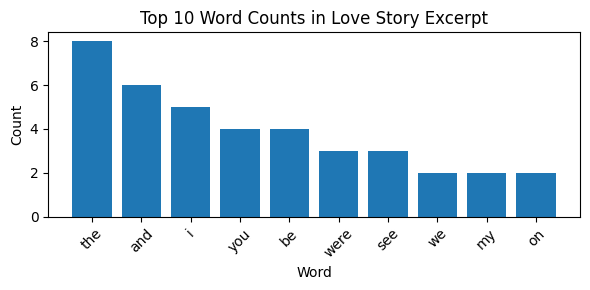

In [2]:
def get_bag_of_words(text):
    """ We want to count how many words there are in the text"""
    words = text.strip().lower().split()
    return Counter(words)

# Example text: biggest pop song of all time
example_text = "We were both young when I first saw you \n I close my eyes and the flashback starts \n I'm standing there \n On a balcony in summer air\n See the lights, see the party, the ball gowns \n See you make your way through the crowd \n And say hello \n Little did I know \n That you were Romeo, you were throwing pebbles \n And my daddy said, 'Stay away from Juliet' \n And I was crying on the staircase \n Begging you, 'Please don't go,' and I said \n 'Romeo, take me somewhere we can be alone \n I'll be waiting, all that's left to do is run \n You'll be the prince and I'll be the princess \n It's a love story, baby, just say, 'Yes''"
print(get_bag_of_words(example_text))

def plot_top_counts(counter, N=10):
    """Plot the counts of the top N elements in a Counter object."""
    top_items = counter.most_common(N)
    labels, counts = zip(*top_items)
    plt.figure(figsize=(6, 3))
    plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.title(f'Top {N} Word Counts in Love Story Excerpt')
    plt.tight_layout()
    plt.show()

# Example (thought the word count distribution is a bit boring here since the text is so short):
word_counts = get_bag_of_words(example_text)
plot_top_counts(word_counts, N=10)

### 2.2 Types of probabilities

Imagine we have a tiny dataset of 10 emails: 2 are spam, 8 are legitimate.

**Prior Probability P(Class):** The baseline probability of a class before seeing any evidence.
- P(spam) = 6/10 = 0.2
- P(not spam) = 4/10 = 0.8

These tell us: "Without reading the email, what are the chances it's spam?"

Another type of probabilities are  **Conditional Probabilities**, written as P(A|B), what is the probability of A _given_ I already know B to be true.
For NB classification we distinghuish between two types of conditional probabilities, as they tell us something different for classification. While it is good to understand these terms know that probability theory does not really care what values we are talking about, it can just be any abstract A or B. For classifcation though we want to predict the probability of a _Class_, given the observed _Evidence_ . 

Thus we disthinghuish between the two conditional probabilities:
1. **Likelihood P(Evidence | Class):** How likely is our evidence if we know the class?
    - So if we see the word "FREE" in an email, we ask: "How often does 'FREE' appear in spam (or in non-spam emails)?"
2. **Posterior Probability P(Class | Evidence):** What we actually want! Given the evidence (the email content), what's the probability of each class?


### 2.3 Bayes' Theorem



Bayes' Theorem lets us flip conditional probabilities:

$$
P(\text{Class} \mid \text{Evidence}) = \frac{P(\text{Evidence} \mid \text{Class}) \times P(\text{Class})}{P(\text{Evidence})}
$$

In plain English: 
> The probability of spam given this email = (How likely this email is if it's spam × How common spam is) / How common this email is in general

Since we're comparing classes, $P(\text{Evidence})$ is the same for both, so we can ignore it:

$$
P(\text{Class} \mid \text{Evidence}) \propto P(\text{Evidence} \mid \text{Class}) \times P(\text{Class})
$$

**The "Naive" Assumption:** To make this practical, we assume all words are independent. For an email with words $w_1, w_2, ..., w_n$:

$$
P(\text{Email} \mid \text{Class}) = P(w_1 \mid \text{Class}) \times P(w_2 \mid \text{Class}) \times \ldots \times P(w_n \mid \text{Class})
$$

This is clearly false in reality (for example if you see "free" you're more likely to see "prize"), but it works surprisingly well!



### 2.4. A Manual Example of applying Bayes' Theorem 
It is good to work out some of these examples on paper to really understand what is happening. Check [this website](https://www.lesswrong.com/w/bayes-rule?lens=high-speed-intro-to-bayes-s-rule) for some further material and examples. I copied one example below, if you don't get the answer immidiately that totally normal. Give yourself some time to work it out. 


Suppose you're screening a set of patients for a disease, which we'll call Diseasitis.[1] Your initial test is a tongue depressor containing a chemical strip, which usually turns black if the patient has Diseasitis.

- Based on prior epidemiology, you expect that around 20% of patients in the screening population have Diseasitis.
- Among patients with Diseasitis, 90% turn the tongue depressor black.
- 30% of the patients without Diseasitis will also turn the tongue depressor black.

What fraction of patients with black tongue depressors have Diseasitis?



 <!-- <details open> -->
 <details>
   <summary><b>Answer</b>: Don't look without coming up with your own solution first </summary>

3/7 or 43%, quickly obtainable as follows: In the screened population, there's 1 sick patient for 4 healthy patients. Sick patients are 3 times more likely to turn the tongue depressor black than healthy patients. (1:4)⋅(3:1)=(3:4) or 3 sick patients to 4 healthy patients among those that turn the tongue depressor black, corresponding to a probability of 3/7=43% that the patient is sick.

 </details>



---
## 3: Naive Bayes' Classifier for Spam detection dataset

### 3.1 Load & Process Dataset: Bag-of-Words

In [3]:
# Load a spam detection dataset from huggingface datasets. 
# Again URL is obtained from link in load_dataset: https://huggingface.co/datasets/Deysi/spam-detection-dataset
full_dataset = load_dataset('Deysi/spam-detection-dataset', split='train')  # Load only first 100 examples for speed
print(f"\nDataset loaded! Number of examples: {len(full_dataset)}")

# shuffle and take the first 1000 examples for quicker processing
full_dataset = full_dataset.shuffle(seed=42)
dataset = full_dataset.select(range(100))

print(f"\nNumber of examples after selection: {len(dataset)}")

labels = [item['label'] for item in dataset]  # labelse are "spam" or "not_spam"
text_data = [item['text'] for item in dataset]


Dataset loaded! Number of examples: 8175

Number of examples after selection: 100


In [4]:
example = dataset[0]

# we can also print it as is, but this is a bit easier to read (put all sentences below each other)
example_text = example['text']
example_text_formatted = example_text.strip().replace('.', '.\n').replace('!', '!\n')
print("## Example text and label:")
print(f"- Example text:\n \"\"\"{example_text_formatted}\"\"\"")
print(f"- Example label: {example['label']}")  

## Example text and label:
- Example text:
 """Looking for quick cash? Look no further!
 Join our exclusive money-making community and start earning thousands today.
 All you need is a computer and internet connection!
 Don't miss out on this amazing opportunity.
"""
- Example label: spam


### 3.2 Computing Prior Probabilities `P(Class)` 
<!-- ## Probabilities step 1: Prior Probabilities `P(Class)`  -->

`P(Class)` allows us to say for each class its probability. Specifically this means what is the frequency of this class in the dataset. While we write it here as the general variable `Class`, when we write it for a specific instance we write it as `P(Class="spam")`, or if it is clear for which variable the instance is we can just say `P("spam")`.
- To compute the prior probability of the "spam" class, we count the number of spam documents and divide by the total number of documents:

$$
P(\text{Class} = \text{spam}) = \frac{\# \text{Spam documents}}{\#\text{Spam documents} + \# \text{Non spam documents}}
$$
- Notation remark: Sometimes we can use "#" as an abbreviation for "Number of", and as this reads easier (and I am lazy), I write it us such.

 <!-- <details open> -->
 <details>
   <summary><b>Remark</b>: Calculating P(Document) - issues </summary>

**Computing `P(Document)`**

For our Naive Bayes Classifier we don't need the prior pobability of a Document but it is nevertheless good to note what it would mean. 
So for the BOW model the probability of a document would be the combined probability of the individual words.
This computes P(Document) based purely on the overall word distribution in the dataset, without considering class labels.

$$
P(\text{word}_i) = \frac{\# \text{word}_i \text{ across all documents}}{\# \text{ word instances (so not just unique) across all documents}}
$$

Then, assuming independence between words (the Naive Bayes assumption), the probability of a document is the product of the probabilities of its words:
$$
P(\text{Document}) = \prod_{i=1}^{n} P(\text{word}_i)^{c_i}
$$

where $c_i$ is the count of word $i$ in the document, and $n$ is the size of our vocabulary.

**Note:** In practice, this probability will be extremely small, so we often work with log probabilities instead.

$$
log (P(\text{Document}) )= \sum_{i=1}^{n} log(P(\text{word}_i)^{c_i})
$$

 </details>

In [5]:
labels_bin = [int(item['label'] == "spam") for item in dataset]  # 1 for spam, 0 for not_spam
prob_spam = sum(labels_bin) / len(labels)
prob_not_spam = 1 - prob_spam

print(f"\nPrior probability of spam: P(spam) = {prob_spam:.3f}")
print(f"Prior probability of not spam: P(not spam) = {prob_not_spam:.3f}")


Prior probability of spam: P(spam) = 0.500
Prior probability of not spam: P(not spam) = 0.500


**Observation:** In this case we see that the dataset is well balanced, which is great! But as you can imagine for many real tasks we will work with very imbalanced datasets. In such imbalanced cases the impact of Naive Bayes really shows it's imporance (remember the manual example in section 3). Interestingly, I just found out that our 50/50 class split is not as unrealistic, as [this source ](https://www.statista.com/statistics/420400/spam-email-traffic-share-annual/)mentions spam is about 45% of all email traffic. 

### 3.3 Computing Likelihood Probabilities

Here's where the "naive" part comes in. We assume that **all words in a document are independent** given the class. Of course in the real world this is not true, for example if a review contains a negative word like "awful" it is much more likely that other negative words will be in that review than positive words. However, like all things in science, this method offers approximation of the truth (the probability of a class in this case), which it turns out is very useful so we keep using it, but do be aware of this limitation.

For a document with words w₁, w₂, ..., wₙ:

```
P(Document | Class) = P(w₁ | Class) × P(w₂ | Class) × ... × P(wₙ | Class)
```

This probability function is a Conditional Probability, as we are computing: what is the probability of having this document, knowing that it belongs to class X (e.g. spam). So if this document looks nothing like other spam documents its probability will be very low. 

For our case we can just count how often each word in our vocabulary appears in each of the class, then we can calculate the probability of w1 given class="spam", by counting how often w1 appears in all the spam documents, and normalizing (dividing) by the total words in that class.


<!-- $$
 P(\text{word}_i | Class=\text{"spam"}) = \frac{\text{\# Occurences word}_i \text{ in all spam documents}}{\text{\# Occurences of word instances (so not just unique) in all spam documents}}
$$ -->

$$
P(\text{word}_i\,|\,\text{Class=spam}) = \frac{\#\text{times word}_i \text{ in all spam documents}}{\#\text{total words in all spam documents}}
$$


#### Practically with Naive Bayes we count the frequencies of each word
Practical training steps:
1. **Count word frequencies** in each class
2. **Calculate probabilities**:
   - P(Class): How common is each class?
   - P(word | Class): How often does each word appear in each class?
3. **Apply smoothing** to handle unseen words


For Prediction:
1. **For each class**, calculate: P(Class) × ∏ P(word | Class) for all words
2. **Choose the class** with the highest probability


#### Coding implementation:

In [6]:
train_data = list(zip(text_data, labels))
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
print(f"Dataset shape: {train_df.shape}")
print(f"\nClass distribution:")
print(train_df['label'].value_counts())
print(f"\nFirst few examples:")
print(train_df.head())

Dataset shape: (100, 2)

Class distribution:
label
spam        50
not_spam    50
Name: count, dtype: int64

First few examples:
                                                text     label
0  Looking for quick cash? Look no further! Join ...      spam
1  Our DaaS platform Quandl is a free and open in...  not_spam
2  Should I worry about having a good IQ to becom...  not_spam
3  Hi all,\nworking on a research project to iden...  not_spam
4  Does anyone know the sources for raw data?\n\n...  not_spam


##### Step 1: Tokenization and Vocabulary Building

In [7]:
def tokenize(text):
    """Simple tokenization: lowercase and split by spaces"""
    return text.lower().split()

# Build vocabulary
vocabulary = set()
for text, _ in train_data:
    vocabulary.update(tokenize(text))

print(f"\nVocabulary size: {len(vocabulary)}")
print(f"First 20 words in vocabulary: {sorted(list(vocabulary))[:20]}")


Vocabulary size: 2073
First 20 words in vocabulary: ['"', '"buy', '"dataisbeautiful"', '"friends"', '"get', '"hey', '"hoarding",', '"howdy', '"inappropriate', '"lose', '"spam', '"upgrade', '"urgent!', '"want', '#', '##', '#baliadventure', '#beachbody', '#fitness', '#followers4life']


##### Step 2: Count Word Frequencies per Class


In [8]:
# Count documents per class
class_counts = Counter([label for _, label in train_data])
total_docs = len(train_data)

print("\nClass distribution:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} documents")

# Count word frequencies per class
word_counts = defaultdict(lambda: defaultdict(int))
total_words = defaultdict(int)

for text, label in train_data:
    words = tokenize(text)
    for word in words:
        word_counts[label][word] += 1
        total_words[label] += 1

print("\nWord counts per class:")
for label in ['spam', 'not_spam']:
    print(f"\n{label}:")
    # Show only top 5 most common words per class (since vocabulary is much larger)
    label_word_counts = word_counts[label]
    top_words = sorted(label_word_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, count in top_words:
        print(f"  '{word}': {count}")


Class distribution:
  spam: 50 documents
  not_spam: 50 documents

Word counts per class:

spam:
  'and': 120
  'you': 91
  'to': 73
  'our': 70
  'the': 67

not_spam:
  'to': 95
  'the': 94
  'i': 91
  'a': 86
  'of': 78


##### Step 3: Calculate Probabilities
**Prior probabilities** (P(Class)):

In [9]:

# Prior probabilities
priors = {}
for cls, count in class_counts.items():
    priors[cls] = count / total_docs
    print(f"P({cls}) = {count}/{total_docs} = {priors[cls]:.3f}")

P(spam) = 50/100 = 0.500
P(not_spam) = 50/100 = 0.500


##### Likelihood probabilities ($P(\text{word} \mid \text{Class})$) -  **Smoothing**

The basic likelihood probability $P(\text{word} \mid \text{Class})$, which provides the likelihood of word $\text{word}$ in a document given that we are in class $\text{Class}$, is:

$$
P(\text{word} \mid \text{class}) = \frac{\text{count}(\text{word}, \text{class})}{\text{total words in class}}
$$

However, since a word can also appear $0$ times for a specific class, to avoid zero probabilities for unseen words, we use **Laplace smoothing** (add-one smoothing):

$$
P(\text{word} \mid \text{class}) = \frac{\text{count}(\text{word}, \text{class}) + \alpha}{\text{total words in class} + \text{vocabulary size}*\alpha}
$$

For our case we use $\alpha = 1$ for simplicity (though keep in mind that varying this parameter might be relevant in other cases)

In [10]:
# Likelihood probabilities with Laplace smoothing
alpha = 1  # Smoothing parameter
vocab_size = len(vocabulary)

def calculate_likelihood(word, cls):
    """Calculate P(word | class) with Laplace smoothing"""
    word_count = word_counts[cls][word]
    total = total_words[cls]
    return (word_count + alpha) / (total + alpha * vocab_size)

# Show some examples
print("\nLikelihood probabilities P(word | class):")
print(f"\nVocabulary size: {vocab_size}")

# Pick some characteristic spam/not_spam words for examples
example_words = ['free', 'call', 'win', 'click', 'urgent']

for label in ['spam', 'not_spam']:
    print(f"\nTotal words in {label}: {total_words[label]}")
    print(f"Examples for {label}:")
    for word in example_words:
        prob = calculate_likelihood(word, label)
        count = word_counts[label][word]
        print(f"  P('{word}' | {label}) = ({count} + 1) / ({total_words[label]} + {vocab_size}) = {prob:.6f}")


Likelihood probabilities P(word | class):

Vocabulary size: 2073

Total words in spam: 2909
Examples for spam:
  P('free' | spam) = (8 + 1) / (2909 + 2073) = 0.001807
  P('call' | spam) = (0 + 1) / (2909 + 2073) = 0.000201
  P('win' | spam) = (8 + 1) / (2909 + 2073) = 0.001807
  P('click' | spam) = (5 + 1) / (2909 + 2073) = 0.001204
  P('urgent' | spam) = (1 + 1) / (2909 + 2073) = 0.000401

Total words in not_spam: 3339
Examples for not_spam:
  P('free' | not_spam) = (5 + 1) / (3339 + 2073) = 0.001109
  P('call' | not_spam) = (0 + 1) / (3339 + 2073) = 0.000185
  P('win' | not_spam) = (0 + 1) / (3339 + 2073) = 0.000185
  P('click' | not_spam) = (0 + 1) / (3339 + 2073) = 0.000185
  P('urgent' | not_spam) = (0 + 1) / (3339 + 2073) = 0.000185


### 3.4 Making Predictions

<!-- ### Step 4: Make Predictions -->

Now let's classify some new emails!

In [11]:
def predict_naive_bayes(text):
    """Predict the class for a text message"""
    words = tokenize(text)
    
    scores = {}
    for cls in ['spam', 'not_spam']:
        # Start with prior probability (in log space to avoid underflow)
        score = np.log(priors[cls])
        
        # Multiply by likelihood of each word (add in log space)
        for word in words:
            if word in vocabulary:
                score += np.log(calculate_likelihood(word, cls))
            else:
                # Unseen word: use smoothing
                score += np.log(alpha / (total_words[cls] + alpha * vocab_size))
        
        scores[cls] = score
    
    # Return class with highest score
    predicted_class = max(scores, key=scores.get)
    return predicted_class, scores

# Test on new messages
test_messages = [
    "Congratulations! You won a free prize. Click here now!",
    "Hi, are we still meeting for lunch tomorrow?",
    "URGENT: Your account will be closed. Call immediately!",
    "Thanks for the document you sent yesterday"
]

print("\n" + "="*60)
print("PREDICTIONS")
print("="*60)

for message in test_messages:
    predicted_class, scores = predict_naive_bayes(message)
    print(f"\nMessage: '{message}'")
    print(f"Log probabilities:")
    for cls, score in scores.items():
        print(f"  {cls}: {score:.2f}")
    print(f"Predicted: {predicted_class}")


PREDICTIONS

Message: 'Congratulations! You won a free prize. Click here now!'
Log probabilities:
  spam: -61.54
  not_spam: -67.06
Predicted: spam

Message: 'Hi, are we still meeting for lunch tomorrow?'
Log probabilities:
  spam: -59.18
  not_spam: -58.89
Predicted: not_spam

Message: 'URGENT: Your account will be closed. Call immediately!'
Log probabilities:
  spam: -59.67
  not_spam: -64.41
Predicted: spam

Message: 'Thanks for the document you sent yesterday'
Log probabilities:
  spam: -47.91
  not_spam: -47.01
Predicted: not_spam



---

<!-- ## 5. Implementation with scikit-learn -->
### 3.5 Using existing package: scikit-learn
While building our own Naive Bayes classifier from scratch is valuable for understanding, in practice we use well-tested libraries like **scikit-learn**. Let's see how the professional version compares to our handmade one.

The scikit-learn implementation involves three components working together:

**CountVectorizer** handles all the messy text preprocessing for us. It takes raw text and converts it into a matrix of word counts—exactly the Bag-of-Words representation we built manually. When you call `fit()`, it builds a vocabulary from your training data, then `transform()` converts any text into counts using that vocabulary. It returns a sparse matrix, which is important: if your vocabulary has 10,000 words but a document only contains 50 unique words, why store 9,950 zeros?

**MultinomialNB** is scikit-learn's Naive Bayes for count data. Under the hood, it's doing exactly what we coded earlier: calculating P(Class) and P(word|Class) for every word in the vocabulary, with Laplace smoothing (controlled by the `alpha` parameter, defaulting to 1.0). The "Multinomial" refers to the statistical distribution it assumes for word counts.

**Pipeline** chains these steps together elegantly. Think of it as a recipe: "First vectorize the text, then classify it." This has a subtle but important benefit—when you call `fit()` on the pipeline, it learns the vocabulary from training data only. When you call `predict()`, it uses that same vocabulary, ensuring train-test consistency. Without a pipeline, you might accidentally introduce data leakage by letting test data influence your vocabulary.

Here's how it all works together:


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline


In [13]:

# Prepare data
X_train = [text for text, _ in train_data]
y_train = [label for _, label in train_data]

# Create a pipeline
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=1.0))
])

# Train
model.fit(X_train, y_train)

# Predict on the same test messages
test_messages_sklearn = [
    "Congratulations! You won a free prize. Click here now!",
    "Hi, are we still meeting for lunch tomorrow?",
    "URGENT: Your account will be closed. Call immediately!",
    "Thanks for the document you sent yesterday"
]

predictions = model.predict(test_messages_sklearn)
probabilities = model.predict_proba(test_messages_sklearn)

print("\n" + "="*60)
print("SCIKIT-LEARN PREDICTIONS")
print("="*60)

for message, pred, probs in zip(test_messages_sklearn, predictions, probabilities):
    print(f"\nMessage: '{message}'")
    # Note: class order is alphabetically sorted in sklearn
    class_labels = model.classes_
    prob_str = ', '.join([f"{label}={prob:.3f}" for label, prob in zip(class_labels, probs)])
    print(f"Probabilities: {prob_str}")


SCIKIT-LEARN PREDICTIONS

Message: 'Congratulations! You won a free prize. Click here now!'
Probabilities: not_spam=0.000, spam=1.000

Message: 'Hi, are we still meeting for lunch tomorrow?'
Probabilities: not_spam=0.860, spam=0.140

Message: 'URGENT: Your account will be closed. Call immediately!'
Probabilities: not_spam=0.002, spam=0.998

Message: 'Thanks for the document you sent yesterday'
Probabilities: not_spam=0.817, spam=0.183


#### Test on the test set


In [14]:
#  Load the test set
full_dataset_test = load_dataset('Deysi/spam-detection-dataset', split='test')  # Load only first 100 examples for speed

full_dataset_test = full_dataset_test.shuffle(seed=42)
# dataset_test = full_dataset_test.select(range(100)) # If you want use a subset for speed
dataset_test = full_dataset_test
print(f"\nNumber of examples after selection: {len(dataset_test)}")

labels_test = [item['label'] == "spam" for item in dataset_test]  # 1 for spam, 0 for not_spam
text_data_test = [item['text'] for item in dataset_test]


Number of examples after selection: 2725


In [15]:
def calculate_test_accuracy(model, text_data_test, labels_test):

    # Convert boolean labels to string labels if needed
    y_test = ['spam' if label else 'not_spam' for label in labels_test]
    
    # Make predictions
    y_pred = model.predict(text_data_test)
    
    # Calculate accuracy
    correct = sum(pred == true for pred, true in zip(y_pred, y_test))
    accuracy = correct / len(y_test)
    
    return accuracy, y_pred, y_test

# Calculate test accuracy
accuracy, y_pred, y_test = calculate_test_accuracy(model, text_data_test, labels_test)

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test Accuracy: {accuracy:.2%} ({int(accuracy * len(y_test))}/{len(y_test)} correct)")



TEST SET EVALUATION
Test Accuracy: 99.41% (2709/2725 correct)


**Observation:** 
- Wow! we see that for this dataset the model already obtains nearly perfect accuracy on the test set (2709 example), while the NB classifier is only trained on 100 example.
- Likely this dataset is fairly simple though. Potential follow-up experiments: 1. Which words are most indicative of a specific class? If we only evaluated 10 or a 100 words in our vocabulator, what would the test accuracy be? 


---

## 4. Extra Material
If you walked through all the above material and feel comfortable implementing similar systems your self this is already great! Below are some extra code samples to help you get familiar with additional tasks and other classifiers.

### 4.1. Another classification task: Sentiment Analysis
While the spam dataset we used was a nice toy example, it is not a very popular dataset, nor very challenging if our Naive Bayes classifier already has 100% accuracy when trained on only 100 examples. 

Let's try with more data to see realistic performance:

In [16]:
# Load IMDB dataset and train Naive Bayes classifier
imdb_dataset = load_dataset('imdb', split='train')  # Use 5000 samples for speed
imdb_test = load_dataset('imdb', split='test')  # Use 1000 test samples

# Prepare data
X_train_imdb = imdb_dataset['text']
y_train_imdb = ['positive' if label == 1 else 'negative' for label in imdb_dataset['label']]
X_test_imdb = imdb_test['text']
y_test_imdb = ['positive' if label == 1 else 'negative' for label in imdb_test['label']]

# Train model
mn_nb_model_imdb = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),  # Limit features for speed
    ('classifier', MultinomialNB(alpha=1.0))
])

mn_nb_model_imdb.fit(X_train_imdb, y_train_imdb)

# Calculate test accuracy
y_pred_imdb_mn = mn_nb_model_imdb.predict(X_test_imdb)
accuracy_imdb_mn = sum(pred == true for pred, true in zip(y_pred_imdb_mn, y_test_imdb)) / len(y_test_imdb)

print("\n" + "="*60)
print("IMDB SENTIMENT CLASSIFICATION")
print("="*60)
print(f"Training samples: {len(X_train_imdb)}")
print(f"Test samples: {len(X_test_imdb)}")
print(f"Test Accuracy: {accuracy_imdb_mn:.2%}")

# Show example predictions
test_examples = [
    "This movie was absolutely fantastic! Great acting and story.",
    "Terrible film, waste of time and money."
]

print("\n### Example predictions:")
for text in test_examples:
    pred = mn_nb_model_imdb.predict([text])[0]
    probs = mn_nb_model_imdb.predict_proba([text])[0]
    print(f"\nReview: '{text[:60]}...'")
    print(f"Predicted: {pred} (confidence: {max(probs):.2%})")


IMDB SENTIMENT CLASSIFICATION
Training samples: 25000
Test samples: 25000
Test Accuracy: 82.34%

### Example predictions:

Review: 'This movie was absolutely fantastic! Great acting and story....'
Predicted: positive (confidence: 78.95%)

Review: 'Terrible film, waste of time and money....'
Predicted: negative (confidence: 99.21%)



### 4.2. Variants of Naive Bayes

There are different variants depending on the type of features:

#### MultinomialNB (What we used)
- For **count data** (word frequencies)
- Best for text classification
- Assumes features follow a multinomial distribution

#### BernoulliNB
- For **binary features** (word present/absent)
- Can work well with short documents
- Assumes features are binary

#### GaussianNB
- For **continuous features**
- Assumes features follow a Gaussian (normal) distribution
- Not typically used for text , very compute heavy as well

In [17]:
# BernoulliNB
bernoulli_model = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier', BernoulliNB(alpha=1.0))
])
bernoulli_model.fit(X_train_imdb, y_train_imdb)
bernoulli_pred = bernoulli_model.predict(X_test_imdb)
accuracy_bernoulli = np.mean(bernoulli_pred == y_test_imdb)


print("\nTest Accuracy Comparison:")
print(f"MultinomialNB: {accuracy_imdb_mn:.2%}")
print(f"BernoulliNB  : {accuracy_bernoulli:.2%}")


Test Accuracy Comparison:
MultinomialNB: 82.34%
BernoulliNB  : 82.60%


### 4.3. (optional) Exercise 

**Task**: Use the Naive Bayes classifier to build a language identifier!

Given the following training data of sentences in different languages, train a classifier to identify the language of new sentences.


In [18]:


# Training data: (sentence, language)
language_data = [
    ("hello how are you", "english"),
    ("good morning everyone", "english"),
    ("bonjour comment allez vous", "french"),
    ("bonne journée à tous", "french"),
    ("hola cómo estás", "spanish"),
    ("buenos días a todos", "spanish"),
]

# Your code here:
# 1. Split into X_train and y_train
# 2. Create and train a Naive Bayes classifier
# 3. Test on new sentences: "hello world", "buenos amigos", "bonjour monde"

# Solution (try yourself first!)
X_lang = [sent for sent, _ in language_data]
y_lang = [lang for _, lang in language_data]

lang_model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(2, 3))),
    ('classifier', MultinomialNB())
])

lang_model.fit(X_lang, y_lang)

test_sentences = ["hello world", "buenos amigos", "bonjour monde"]
lang_predictions = lang_model.predict(test_sentences)

print("\n" + "="*60)
print("LANGUAGE IDENTIFICATION")
print("="*60)

for sentence, lang in zip(test_sentences, lang_predictions):
    print(f"'{sentence}' → {lang}")


LANGUAGE IDENTIFICATION
'hello world' → english
'buenos amigos' → spanish
'bonjour monde' → french


---

## Self-Check Questions

Test your understanding of Naive Bayes and its application in this notebook:

1.  What does the "naive" assumption in Naive Bayes refer to? Why is it important for the algorithm? 
2.  How do you compute the prior probability $P(\text{Class})$ from a labeled dataset? 
3.  Explain how Laplace (add-one) smoothing helps when calculating $P(\text{word} \mid \text{Class})$. 
4.  Given a new email, describe the steps Naive Bayes uses to predict whether it is spam or not. 
5.  Why do we often use log probabilities instead of multiplying raw probabilities directly? 
6.  What are some limitations of Naive Bayes for text classification? 
7.  How does the Bag-of-Words representation affect the information available to the classifier? 
8.  How does the vocabulary size influence the likelihood calculations and smoothing? 
9.  If a word in a test document was never seen in training, how does Naive Bayes handle it? 

---

### Further Reading

- [Scikit-learn Naive Bayes Documentation](https://scikit-learn.org/stable/modules/naive_bayes.html)
- Jurafsky & Martin, "Speech and Language Processing" (Chapter on Text Classification)
- Manning et al., "Introduction to Information Retrieval" (Chapter 13)
